# Analysis of Search Everywhere Usage: Comparison of Experimental Groups

## Introduction and Research Objective

The aim of this study is to analyze a synthetic dataset containing information on the usage of the Search Everywhere feature, and to identify statistically significant differences between experimental groups 0 and 1. The analysis encompasses data processing, exploratory analysis, statistical testing, and visualization of results.

## Data Loading and Preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from scipy import stats
from scipy.stats import entropy
from collections import Counter
from statsmodels.stats.proportion import proportions_ztest

In [3]:
df = pd.read_csv('2024InternshipData.csv')

In [4]:
df['event_data'] = df['event_data'].apply(json.loads)
df['searchStateFeatures'] = df['event_data'].apply(lambda x: x['searchStateFeatures'] if 'searchStateFeatures' in x else None)
df['experimentGroup'] = df['event_data'].apply(lambda x: x['experimentGroup'] if 'experimentGroup' in x else None)
df['selectedIndexes'] = df['event_data'].apply(lambda x: x['selectedIndexes'] if 'selectedIndexes' in x else None)
df['eventIndex'] = df['event_data'].apply(lambda x: x['eventIndex'] if 'eventIndex' in x else None)
df['session_id'] = df['event_data'].apply(lambda x: x['session_id'] if 'session_id' in x else None)

In [5]:
df['time'] = pd.to_datetime(df['time_epoch'], unit='ms')
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour

In [6]:
df['has_selection'] = df['selectedIndexes'].notnull()

In [7]:
def get_search_state_features_keys(event_data):
    return list(event_data['searchStateFeatures'].keys())

all_keys = df['event_data'].apply(get_search_state_features_keys)

key_counts = Counter([key for keys in all_keys for key in keys])

print("Keys in searchStateFeatures and their frequencies:")
for key, count in key_counts.items():
    print(f"{key}: {count}")

Keys in searchStateFeatures and their frequencies:
queryLength: 107344


In [8]:
df['queryLength'] = df['searchStateFeatures'].apply(lambda x: x['queryLength'] if 'queryLength' in x else None)

## Exploratory Data Analysis

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107344 entries, 0 to 107343
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   time_epoch           107344 non-null  float64       
 1   device_id            107344 non-null  object        
 2   event_data           107344 non-null  object        
 3   event_id             107344 non-null  object        
 4   searchStateFeatures  107344 non-null  object        
 5   experimentGroup      107344 non-null  int64         
 6   selectedIndexes      8728 non-null    object        
 7   eventIndex           107344 non-null  int64         
 8   session_id           107344 non-null  object        
 9   time                 107344 non-null  datetime64[ns]
 10  date                 107344 non-null  object        
 11  hour                 107344 non-null  int32         
 12  has_selection        107344 non-null  bool          
 13  queryLength   

In [10]:
print(df.head())

     time_epoch                         device_id  \
0  1.699911e+12  9476ff0ed144326d4a58e066f6fefdcc   
1  1.699911e+12  9476ff0ed144326d4a58e066f6fefdcc   
2  1.699911e+12  9476ff0ed144326d4a58e066f6fefdcc   
3  1.699911e+12  9476ff0ed144326d4a58e066f6fefdcc   
4  1.699911e+12  9476ff0ed144326d4a58e066f6fefdcc   

                                          event_data         event_id  \
0  {'session_id': '65ba8f8e3a23c60ec6a8d6e83e6ad2...  searchRestarted   
1  {'session_id': '65ba8f8e3a23c60ec6a8d6e83e6ad2...  searchRestarted   
2  {'session_id': '65ba8f8e3a23c60ec6a8d6e83e6ad2...  searchRestarted   
3  {'session_id': '65ba8f8e3a23c60ec6a8d6e83e6ad2...  searchRestarted   
4  {'session_id': '65ba8f8e3a23c60ec6a8d6e83e6ad2...  sessionFinished   

   searchStateFeatures  experimentGroup selectedIndexes  eventIndex  \
0  {'queryLength': 11}                1            None           0   
1  {'queryLength': 12}                1            None           1   
2  {'queryLength': 13}       

In [11]:
print(df.describe())

         time_epoch  experimentGroup     eventIndex  \
count  1.073440e+05    107344.000000  107344.000000   
mean   1.708440e+12         0.524780       5.254127   
min    1.699911e+12         0.000000       0.000000   
25%    1.704178e+12         0.000000       1.000000   
50%    1.708461e+12         1.000000       4.000000   
75%    1.712629e+12         1.000000       7.000000   
max    1.716995e+12         1.000000      78.000000   
std    4.917107e+09         0.499388       5.787870   

                                time           hour    queryLength  
count                         107344  107344.000000  107344.000000  
mean   2024-02-20 14:33:28.751455488      11.521967      10.669744  
min       2023-11-13 21:31:56.038000       0.000000       0.000000  
25%    2024-01-02 06:53:29.989093376       6.000000       3.000000  
50%    2024-02-20 20:27:21.921015040      12.000000       7.000000  
75%    2024-04-09 02:11:34.840879872      17.000000      13.000000  
max       2024-05-29 

In [12]:
print(df.isnull().sum())

time_epoch                 0
device_id                  0
event_data                 0
event_id                   0
searchStateFeatures        0
experimentGroup            0
selectedIndexes        98616
eventIndex                 0
session_id                 0
time                       0
date                       0
hour                       0
has_selection              0
queryLength                0
dtype: int64


Based on the initial data exploration, I can provide a comprehensive overview of the dataset and its characteristics. The dataset contains 107,344 entries with 14 columns, providing a rich source of information for our analysis of the Search Everywhere feature.

Key observations from the dataset include:

- Temporal range: The data spans from November 13, 2023, to May 29, 2024, providing a substantial period for analysis.
- Query length: The average query length is approximately 10.67 characters, with a wide range from 0 to 764 characters.
- Event distribution: Each session contains multiple events, with an average of about 5.25 events per session.
- Missing data: The 'selectedIndexes' column has a significant number of null values (98,616), which may require special attention during analysis.

This initial study showed the suitability of the data for further research and provided a general understanding of the data. In the following sections, we will delve deeper into specific aspects of the data to uncover meaningful insights and patterns.


## Preparatory calculations

In [13]:
event_counts = df['event_id'].value_counts()

In [14]:
session_event_counts = df.groupby(['device_id', 'session_id']).size().reset_index(name='event_count')

In [15]:
df['time_diff'] = df.groupby(['device_id', 'session_id'])['time'].diff().dt.total_seconds()

In [16]:
selection_rate = df['has_selection'].mean()

In [17]:
session_duration = df.groupby(['device_id', 'session_id']).agg({
    'time': lambda x: (x.max() - x.min()).total_seconds()
}).reset_index()

In [18]:
hourly_activity = df['hour'].value_counts().sort_index()

In [19]:
daily_activity = df.groupby('date').size().reset_index(name='count')
daily_activity['date'] = pd.to_datetime(daily_activity['date'])

In [20]:
session_duration_by_group = df.groupby(['device_id', 'session_id', 'experimentGroup']).agg({
    'time': lambda x: (x.max() - x.min()).total_seconds()
}).reset_index()

In [21]:
def extract_indexes(indexes_list):
    return [index for sublist in indexes_list if sublist is not None for index in sublist]

all_indexes = extract_indexes(df['selectedIndexes'].dropna().tolist())

all_indexes_group_0 = extract_indexes(df[df['experimentGroup'] == 0]['selectedIndexes'].dropna().tolist())
all_indexes_group_1 = extract_indexes(df[df['experimentGroup'] == 1]['selectedIndexes'].dropna().tolist())

## Visualization of Search Everywhere metrics

For a more in-depth understanding of the provided data, let's examine the various visualizations presented.

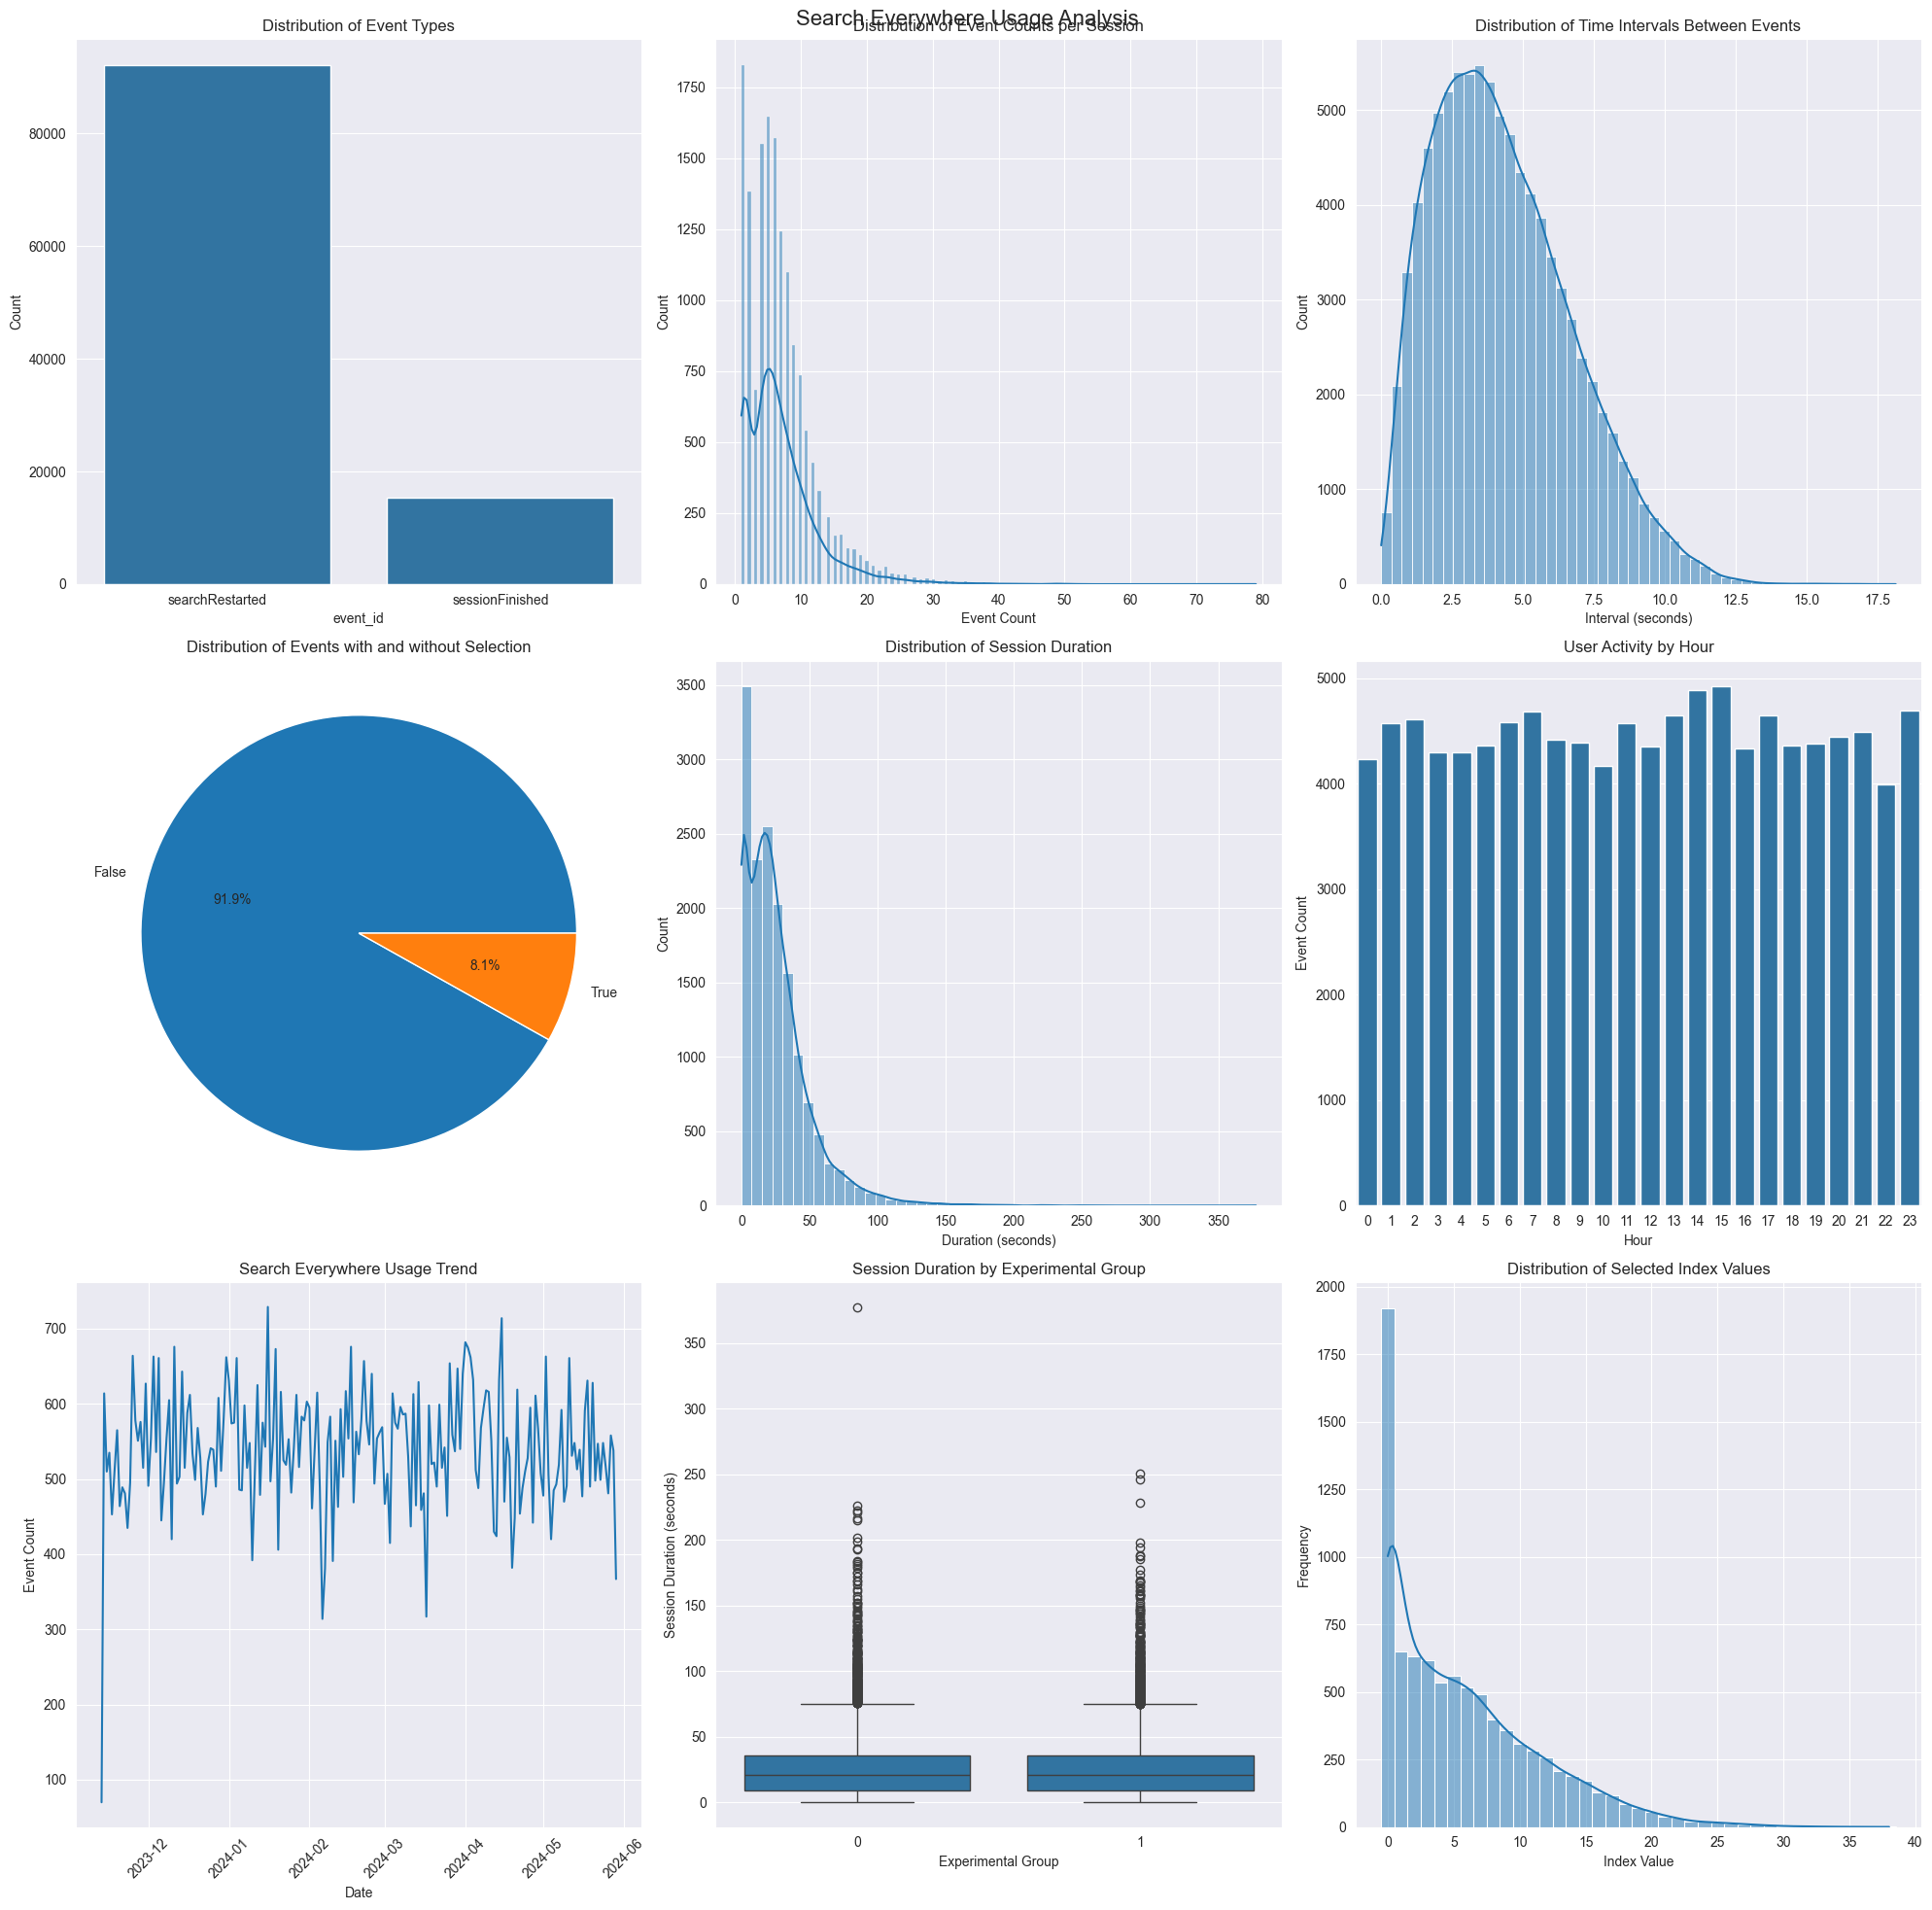

In [22]:
# Set up the matplotlib figure with a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Search Everywhere Usage Analysis', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# 1. Event type distribution
sns.barplot(x=event_counts.index, y=event_counts.values, ax=axes[0])
axes[0].set_title('Distribution of Event Types')
axes[0].set_ylabel('Count')

# 2. Event count per session
sns.histplot(session_event_counts['event_count'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Event Counts per Session')
axes[1].set_xlabel('Event Count')

# 3. Time intervals between events
sns.histplot(df['time_diff'].dropna(), kde=True, bins=50, ax=axes[2])
axes[2].set_title('Distribution of Time Intervals Between Events')
axes[2].set_xlabel('Interval (seconds)')

# 4. Result selection rate
df['has_selection'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[3])
axes[3].set_title('Distribution of Events with and without Selection')
axes[3].set_ylabel('')

# 5. Session duration
sns.histplot(session_duration['time'], kde=True, bins=50, ax=axes[4])
axes[4].set_title('Distribution of Session Duration')
axes[4].set_xlabel('Duration (seconds)')

# 6. Hourly activity
sns.barplot(x=hourly_activity.index, y=hourly_activity.values, ax=axes[5])
axes[5].set_title('User Activity by Hour')
axes[5].set_xlabel('Hour')
axes[5].set_ylabel('Event Count')

# 7. Usage trends over time
axes[6].plot(daily_activity['date'], daily_activity['count'])
axes[6].set_title('Search Everywhere Usage Trend')
axes[6].set_xlabel('Date')
axes[6].set_ylabel('Event Count')
axes[6].tick_params(axis='x', rotation=45)

# 8. Session duration by experimental groups
sns.boxplot(x='experimentGroup', y='time', data=session_duration_by_group, ax=axes[7])
axes[7].set_title('Session Duration by Experimental Group')
axes[7].set_xlabel('Experimental Group')
axes[7].set_ylabel('Session Duration (seconds)')

# 9. Index value distribution
sns.histplot(all_indexes, kde=True, discrete=True, ax=axes[8])
axes[8].set_title('Distribution of Selected Index Values')
axes[8].set_xlabel('Index Value')
axes[8].set_ylabel('Frequency')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

The visualizations offer valuable insights into the usage patterns of the Search Everywhere feature. Notably, the Distribution of Event Types graph shows a significant prevalence of "searchRestarted" events compared to "sessionFinished" events, indicating frequent search refinements by users.

The User Activity by Hour graph demonstrates consistent usage throughout the day, with slight peaks during typical working hours. This pattern implies that the Search Everywhere feature is an integral part of users' workflows across different time zones.

Interestingly, the Search Everywhere Usage Trend over time shows fluctuations but no clear upward or downward trend, indicating stable usage of the feature over the observed period.

The Distribution of Time Intervals Between Events and Distribution of Session Duration graphs both exhibit right-skewed distributions, suggesting that most interactions with the feature are quick, but there are occasional longer sessions or gaps between events.

Lastly, the Session Duration by Experimental Group boxplot doesn't show a clear difference between the two groups. We will continue our analysis to understand the difference/similarity between the groups in more detail


## Comparative Analysis of Index Selection Patterns Across Experimental Groups

### Visual Exploration of Index Value Distributions

To explore the details of the similarity/differences of the groups, let's take a look at the graphs based on information about the selected indexes

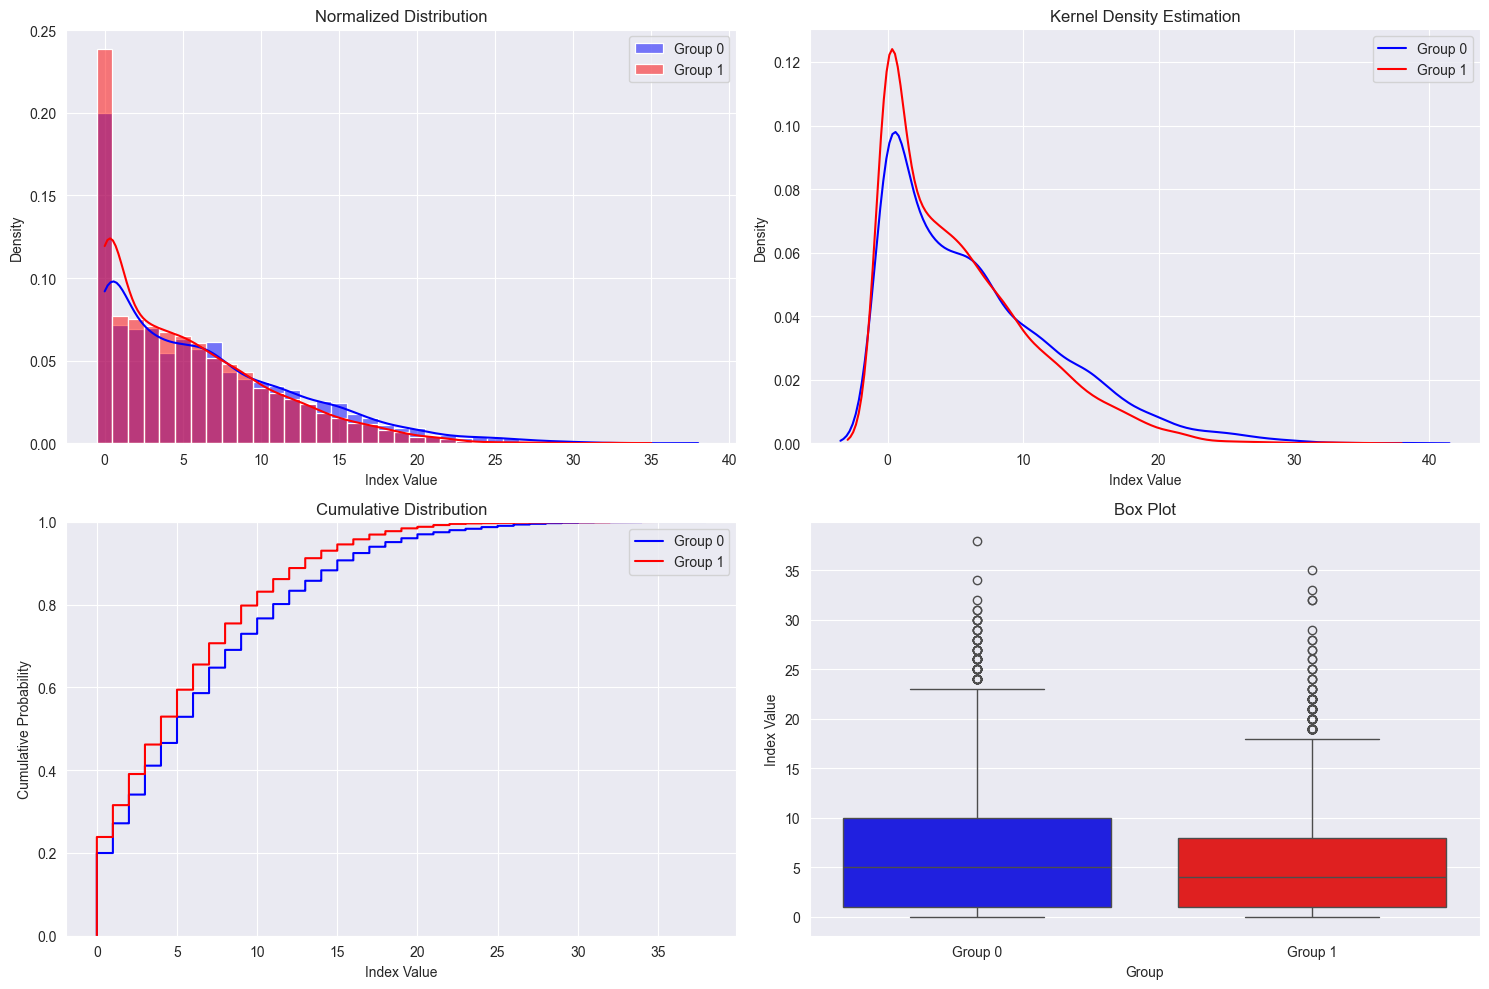

In [25]:
plt.figure(figsize=(15, 10))

# 1. Normalized histogram
plt.subplot(2, 2, 1)
sns.histplot(all_indexes_group_0, stat="density", kde=True, discrete=True, color='blue', alpha=0.5, label='Group 0')
sns.histplot(all_indexes_group_1, stat="density", kde=True, discrete=True, color='red', alpha=0.5, label='Group 1')
plt.title('Normalized Distribution')
plt.xlabel('Index Value')
plt.ylabel('Density')
plt.legend()

# 2. Kernel Density Estimation (KDE)
plt.subplot(2, 2, 2)
sns.kdeplot(all_indexes_group_0, color='blue', label='Group 0')
sns.kdeplot(all_indexes_group_1, color='red', label='Group 1')
plt.title('Kernel Density Estimation')
plt.xlabel('Index Value')
plt.ylabel('Density')
plt.legend()

# 3. Cumulative Distribution
plt.subplot(2, 2, 3)
sns.ecdfplot(all_indexes_group_0, color='blue', label='Group 0')
sns.ecdfplot(all_indexes_group_1, color='red', label='Group 1')
plt.title('Cumulative Distribution')
plt.xlabel('Index Value')
plt.ylabel('Cumulative Probability')
plt.legend()

# 4. Box Plot
plt.subplot(2, 2, 4)
sns.boxplot(data=[all_indexes_group_0, all_indexes_group_1], palette=['blue', 'red'])
plt.title('Box Plot')
plt.xlabel('Group')
plt.ylabel('Index Value')
plt.xticks([0, 1], ['Group 0', 'Group 1'])

plt.tight_layout()
plt.show()

Analyzing the visualization reveals several key insights into the behavior of users in Group 0 and Group 1:

Subtle group differences: Group 1 exhibits a slightly higher tendency to select the top result (index 0) compared to Group 0, as seen in the Normalized Distribution graph.

Rapid decay in selection frequency: The Cumulative Distribution graph shows that a large proportion of selections occur within the first 5-10 results for both groups, with Group 1 reaching higher cumulative probabilities faster.

Similar overall distributions: The Box Plot and Kernel Density Estimation indicate that while there are minor differences, the overall distribution of selections is quite similar between the two groups.

Presence of outliers: The Box Plot reveals outliers in both groups, suggesting that while rare, some users do select results from much lower positions in the list.

These observations suggest that while the experimental conditions may have induced some subtle changes in user behavior, particularly in the selection of top results, the overall pattern of interaction with the Search Everywhere feature remains largely consistent across both groups. This provides a foundation for further statistical analysis to determine the significance and implications of these observed differences.

#### Visualization of the index distribution

In [23]:
def calculate_percentages(group_data, selections):
    unique_indexes = np.unique(group_data)
    percentages = {}
    for idx in unique_indexes:
        percentages[idx] = (np.sum(group_data == idx) / selections) * 100
    return percentages

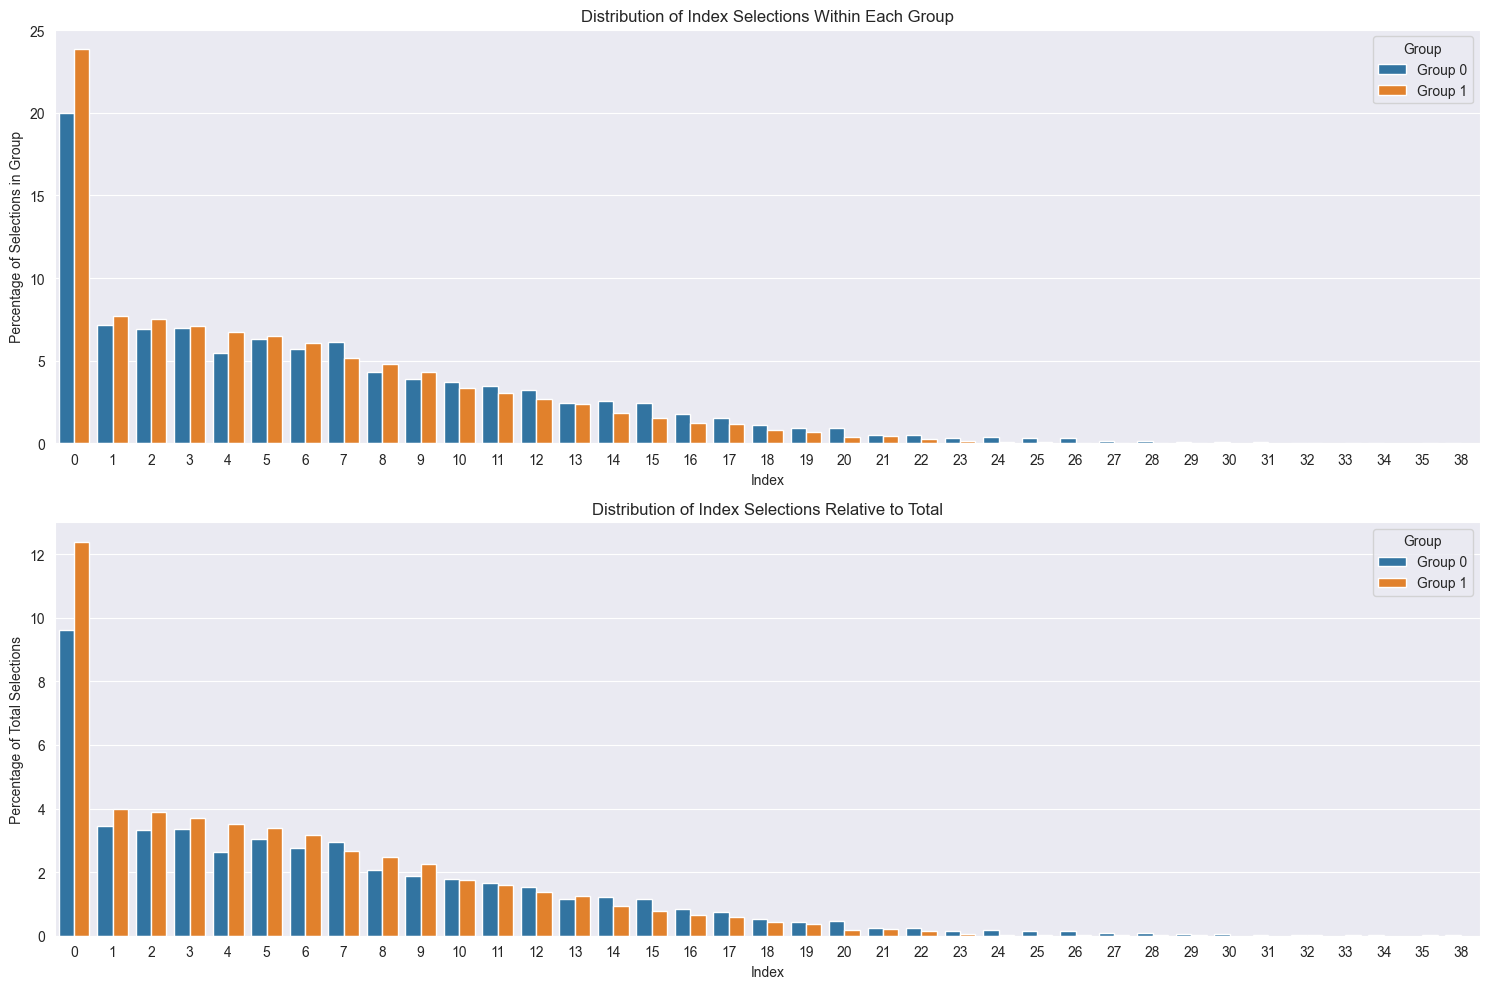

In [55]:
# Assuming all_indexes_group_0 and all_indexes_group_1 are already defined
total_selections_0 = len(all_indexes_group_0)
total_selections_1 = len(all_indexes_group_1)
total_selections = total_selections_0 + total_selections_1

# Calculate percentages for each group
percentages_0_within = calculate_percentages(all_indexes_group_0, total_selections_0)
percentages_1_within = calculate_percentages(all_indexes_group_1, total_selections_1)
percentages_0_overall = calculate_percentages(all_indexes_group_0, total_selections)
percentages_1_overall = calculate_percentages(all_indexes_group_1, total_selections)

# Create DataFrames for convenient plotting
df_within = pd.DataFrame({
    'Index': list(percentages_0_within.keys()) + list(percentages_1_within.keys()),
    'Percentage': list(percentages_0_within.values()) + list(percentages_1_within.values()),
    'Group': ['Group 0'] * len(percentages_0_within) + ['Group 1'] * len(percentages_1_within)
})

df_overall = pd.DataFrame({
    'Index': list(percentages_0_overall.keys()) + list(percentages_1_overall.keys()),
    'Percentage': list(percentages_0_overall.values()) + list(percentages_1_overall.values()),
    'Group': ['Group 0'] * len(percentages_0_overall) + ['Group 1'] * len(percentages_1_overall)
})

# Plot the graphs
plt.figure(figsize=(15, 10))

# Graph of percentages within each group
plt.subplot(2, 1, 1)
sns.barplot(x='Index', y='Percentage', hue='Group', data=df_within)
plt.title('Distribution of Index Selections Within Each Group')
plt.ylabel('Percentage of Selections in Group')

# Graph of percentages relative to total selections
plt.subplot(2, 1, 2)
sns.barplot(x='Index', y='Percentage', hue='Group', data=df_overall)
plt.title('Distribution of Index Selections Relative to Total')
plt.ylabel('Percentage of Total Selections')

plt.tight_layout()
plt.show()


Continuing our analysis of the Search Everywhere feature, we now turn our attention to the distribution of index selections within each experimental group. This visualization provides valuable insights into user behavior and the effectiveness of search result rankings.

There is a clear preference for selecting the first item (index 0) in the search results, with Group 1 showing an even stronger tendency towards this behavior. This "top result bias" is a common phenomenon in search interfaces, but the magnitude of the difference between the first and subsequent results is particularly noteworthy.

Another key observation is the subtle but consistent difference between Group 0 and Group 1 across most index positions. Group 1 generally shows a slightly higher selection rate for lower-indexed results and a lower rate for higher-indexed ones. This could indicate that the experimental condition for Group 1 may be influencing user behavior, possibly by improving the relevance of top results or changing the way results are presented.

These findings have important implications for the design and optimization of the Search Everywhere feature. The strong preference for top results underscores the critical importance of ensuring high-quality, relevant results in the first few positions. However, the non-trivial selection rates for lower positions also suggest value in providing a diverse range of results to cater to various user needs.

In our next steps, we'll delve deeper into the statistical significance of these observed differences between the experimental groups and explore how these patterns correlate with other metrics of user satisfaction and search efficiency.

### Summary Statistics of Selection Frequency

In [56]:
print(f"Total selections in Group 0: {total_selections_0}")
print(f"Total selections in Group 1: {total_selections_1}")
print(f"Total number of selections: {total_selections}")

Total selections in Group 0: 4193
Total selections in Group 1: 4535
Total number of selections: 8728


The nearly equal distribution of selections between Group 0 (4,193) and Group 1 (4,535) provides a balanced dataset for our analysis. This similarity in sample sizes enhances the reliability of our comparisons between the two experimental groups, allowing for more robust statistical inferences about the differences in user behavior and the impact of the experimental conditions.

### Statistical Analysis of Index 0 Selection Across Groups

**Hypotheses:**

- Null Hypothesis (H₀): There is no significant difference in the proportion of index 0 selections between Group 0 and Group 1.
- Alternative Hypothesis (H₁): There is a significant difference in the proportion of index 0 selections between Group 0 and Group 1.

In [26]:
def compare_index_0_proportions(group_0, group_1):
    # Count the number of index 0 selections in each group
    count_0 = np.sum(np.array(group_0) == 0)
    count_1 = np.sum(np.array(group_1) == 0)
    
    # Total number of selections in each group
    n_0 = len(group_0)
    n_1 = len(group_1)
    
    # Conduct z-test
    counts = np.array([count_0, count_1])
    nobs = np.array([n_0, n_1])
    
    z_stat, p_value = proportions_ztest(counts, nobs)
    
    print(f"Proportion of index 0 selections in group 0: {count_0/n_0:.4f}")
    print(f"Proportion of index 0 selections in group 1: {count_1/n_1:.4f}")
    print(f"Z-statistic: {z_stat:.4f}")
    print(f"p-value: {p_value:.15f}")
    
    if p_value < 0.05:
        print("Reject the null hypothesis. There is a statistically significant difference in the proportions of index 0 selections between the groups.")
    else:
        print("Fail to reject the null hypothesis. There is no statistically significant difference in the proportions of index 0 selections between the groups.")

In [27]:
compare_index_0_proportions(all_indexes_group_0, all_indexes_group_1)

Proportion of index 0 selections in group 0: 0.1999
Proportion of index 0 selections in group 1: 0.2386
Z-statistic: -4.3643
p-value: 0.000012752049708
Reject the null hypothesis. There is a statistically significant difference in the proportions of index 0 selections between the groups.


This finding indicates that the experimental condition applied to Group 1 has indeed influenced user interaction with the Search Everywhere feature. The analysis reveals a statistically significant difference in the proportion of top result (index 0) selections between the two groups (23.86% for Group 1 vs 19.99% for Group 0). While the absolute difference of about 4 percentage points might seem modest, its statistical significance suggests a meaningful shift in user behavior. 

Next, we will look at and check exactly how the proportion of index selection differs from 0

**Hypotheses:**

- Null Hypothesis (H₀): The proportion of index 0 selections in Group 1 is less than or equal to the proportion in Group 0.
- Alternative Hypothesis (H₁): The proportion of index 0 selections in Group 1 is greater than the proportion in Group 0.

In [28]:
def compare_index_0_proportions_one_sided(group_0, group_1):
    # Count the number of index 0 selections in each group
    count_0 = np.sum(np.array(group_0) == 0)
    count_1 = np.sum(np.array(group_1) == 0)
    
    # Total number of selections in each group
    n_0 = len(group_0)
    n_1 = len(group_1)
    
    # Conduct one-sided z-test
    counts = np.array([count_1, count_0])  # Order changed as we're testing if group 1 is larger
    nobs = np.array([n_1, n_0])
    
    z_stat, p_value = proportions_ztest(counts, nobs, alternative='larger')
    
    print(f"Proportion of index 0 selections in group 0: {count_0/n_0:.4f}")
    print(f"Proportion of index 0 selections in group 1: {count_1/n_1:.4f}")
    print(f"Z-statistic: {z_stat:.4f}")
    print(f"p-value (one-sided): {p_value:.15f}")
    
    if p_value < 0.05:
        print("Reject the null hypothesis. There is statistically significant evidence that the proportion of index 0 selections in group 1 is greater than in group 0.")
    else:
        print("Fail to reject the null hypothesis. There is no statistically significant evidence that the proportion of index 0 selections in group 1 is greater than in group 0.")

In [29]:
compare_index_0_proportions_one_sided(all_indexes_group_0, all_indexes_group_1)

Proportion of index 0 selections in group 0: 0.1999
Proportion of index 0 selections in group 1: 0.2386
Z-statistic: 4.3643
p-value (one-sided): 0.000006376024854
Reject the null hypothesis. There is statistically significant evidence that the proportion of index 0 selections in group 1 is greater than in group 0.


This significant increase in top result selection (from 19.99% to 23.86%) suggests that the changes implemented for Group 1 have successfully improved the relevance or appeal of the first search result. This shift in user behavior could indicate enhanced search accuracy or a more effective presentation of results.

### Distribution of Choices Hypothesis

**Hypotheses:**

- Null Hypothesis (H₀): The distribution of index selections is the same for both groups.
- Alternative Hypothesis (H₁): The distribution of index selections differs between the two groups.


In [53]:
def extract_indexes(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def flatten_and_count(series):
    return Counter(extract_indexes(series.dropna().tolist()))

def test_distribution_hypothesis(df_x):
    group_0 = df_x[df_x['experimentGroup'] == 0]['selectedIndexes']
    group_1 = df_x[df_x['experimentGroup'] == 1]['selectedIndexes']
    
    count_0 = flatten_and_count(group_0)
    count_1 = flatten_and_count(group_1)
    
    indexes = sorted(set(count_0.keys()) | set(count_1.keys()))
    
    observed = pd.DataFrame({
        'Group 0': [count_0.get(idx, 0) for idx in indexes],
        'Group 1': [count_1.get(idx, 0) for idx in indexes]
    }, index=indexes)
    
    chi2, p_value, dof, expected = stats.chi2_contingency(observed)
    
    print("Hypothesis about the distribution of choices:")
    print(f"Chi-squared statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.15f}")
    print(f"Degrees of freedom: {dof}")
    print("Conclusion: ", "Reject H0 (distributions differ)" if p_value < 0.05 else "Do not reject H0 (insufficient evidence of difference in distributions)")

In [54]:
test_distribution_hypothesis(df)

1. Hypothesis about the distribution of choices:
Chi-squared statistic: 122.8897
p-value: 0.000000000020192
Degrees of freedom: 36
Conclusion:  Reject H0 (distributions differ)


Our chi-square test reveals a significant difference in the distribution of index selections between Group 0 and Group 1 (χ² = 122.8897, p < 0.001). This result strongly suggests that the experimental condition has altered not just the likelihood of selecting the top result, but the overall pattern of how users interact with search results across different positions.

### Mean Choice Index Hypothesis

**Hypotheses:**

- Null Hypothesis (H₀): The mean index of selections is the same for both groups.
- Alternative Hypothesis (H₁): The mean index of selections differs between the two groups.


In [44]:
def test_mean_index_hypothesis(df_x):
    group_0 = extract_indexes(df_x[df_x['experimentGroup'] == 0]['selectedIndexes'].dropna().tolist())
    group_1 = extract_indexes(df_x[df_x['experimentGroup'] == 1]['selectedIndexes'].dropna().tolist())
    
    t_stat, p_value = stats.ttest_ind(group_0, group_1)
    
    print("Hypothesis about the mean choice index:")
    print(f"Mean index in group 0: {np.mean(group_0):.2f}")
    print(f"Mean index in group 1: {np.mean(group_1):.2f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.20f}")
    print("Conclusion: ", "Reject H0 (means differ)" if p_value < 0.05 else "Do not reject H0 (insufficient evidence of difference in means)")


In [45]:
test_mean_index_hypothesis(df)


2. Hypothesis about the mean choice index:
Mean index in group 0: 6.44
Mean index in group 1: 5.34
T-statistic: 8.9412
p-value: 0.00000000000000000046
Conclusion:  Reject H0 (means differ)


The t-test results show a significant difference in the mean index of selections between Group 0 (M = 6.44) and Group 1 (M = 5.34), t = 8.9412, p < 0.001. This finding indicates that users in Group 1 tend to select results that are, on average, higher up in the list compared to users in Group 0. This shift towards higher-ranked selections could imply improved relevance of top results or changes in how users perceive and interact with the search interface.

### Nonparametric Index Analysis

**Hypotheses:**

- Null Hypothesis (H₀): The distribution of index selections in Group 1 is not shifted towards lower values compared to Group 0.
- Alternative Hypothesis (H₁): The distribution of index selections in Group 1 is shifted towards lower values compared to Group 0.


In [51]:
def nonparametric_index_analysis(df_x):
    group_0 = extract_indexes(df_x[df_x['experimentGroup'] == 0]['selectedIndexes'].dropna().tolist())
    group_1 = extract_indexes(df_x[df_x['experimentGroup'] == 1]['selectedIndexes'].dropna().tolist())
    
    # Mann-Whitney test
    statistic, p_value = stats.mannwhitneyu(group_1, group_0, alternative='less')
    
    print("Nonparametric analysis of choice indexes:")
    print(f"Median of indexes in group 0: {np.median(group_0):.2f}")
    print(f"Median of indexes in group 1: {np.median(group_1):.2f}")
    print(f"U-statistic: {statistic:.4f}")
    print(f"p-value (one-sided): {p_value:.20f}")
    print("Conclusion: ", "Reject H0 (indexes in group 1 are statistically significantly smaller)" if p_value < 0.05 else "Do not reject H0 (insufficient evidence that indexes in group 1 are smaller)")

    # Descriptive statistics
    print("\nDescriptive statistics:")
    print("Group 0:")
    print(pd.Series(group_0).describe())
    print("\nGroup 1:")
    print(pd.Series(group_1).describe())

In [52]:
nonparametric_index_analysis(df)


Nonparametric analysis of choice indexes:
Median of indexes in group 0: 5.00
Median of indexes in group 1: 4.00
U-statistic: 8630201.0000
p-value (one-sided): 0.00000000000002970491
Conclusion:  Reject H0 (indexes in group 1 are statistically significantly smaller)

Descriptive statistics:
Group 0:
count    4193.000000
mean        6.436680
std         6.163165
min         0.000000
25%         1.000000
50%         5.000000
75%        10.000000
max        38.000000
dtype: float64

Group 1:
count    4535.000000
mean        5.338037
std         5.309121
min         0.000000
25%         1.000000
50%         4.000000
75%         8.000000
max        35.000000
dtype: float64


The Mann-Whitney U test provides further evidence of a significant shift in user behavior (U = 8630201, p < 0.001). The median index selection for Group 1 (Mdn = 4) is lower than that of Group 0 (Mdn = 5), confirming that users in the experimental group are more likely to select results closer to the top of the list.
The descriptive statistics reinforce these findings, showing lower values across all quartiles for Group 1 compared to Group 0. This consistent pattern across different statistical approaches strengthens our confidence in the impact of the experimental condition on user behavior.


### Diversity Analysis of Selection Patterns Using Entropy

In [34]:
def test_diversity_hypothesis(df_x):
    def calculate_entropy(group):
        flattened = extract_indexes(group.dropna().tolist())
        value_counts = pd.Series(flattened).value_counts(normalize=True)
        return entropy(value_counts)
    
    group_0 = df_x[df_x['experimentGroup'] == 0]['selectedIndexes']
    group_1 = df_x[df_x['experimentGroup'] == 1]['selectedIndexes']
    
    entropy_0 = calculate_entropy(group_0)
    entropy_1 = calculate_entropy(group_1)
    
    print("Hypothesis about the diversity of choices:")
    print(f"Entropy in group 0: {entropy_0:.4f}")
    print(f"Entropy in group 1: {entropy_1:.4f}")
    print("Conclusion: The group with lower entropy has less diversity of choices")


In [35]:
test_diversity_hypothesis(df)


4. Hypothesis about the diversity of choices:
Entropy in group 0: 2.8821
Entropy in group 1: 2.7037
Conclusion: The group with lower entropy has less diversity of choices


This finding aligns with our previous observations and adds a new dimension to our understanding of the experimental condition's impact. The lower entropy in Group 1 suggests that the changes implemented have not only shifted selections towards higher-ranked results but have also concentrated user choices more tightly around certain indices.


### Analysis of Top-N Index Concentration

**Hypotheses:**

- Null Hypothesis (H₀): The concentration of selections in the top 5 results is the same or lower in Group 1 compared to Group 0.
- Alternative Hypothesis (H₁): The concentration of selections in the top 5 results is higher in Group 1 compared to Group 0.

In [49]:
def test_concentration_hypothesis(df_x, N=5):
    def concentration(group):
        flattened = extract_indexes(group.dropna().tolist())
        return sum(1 for item in flattened if item < N) / len(flattened)
    
    group_0 = df_x[df_x['experimentGroup'] == 0]['selectedIndexes']
    group_1 = df_x[df_x['experimentGroup'] == 1]['selectedIndexes']
    
    conc_0 = concentration(group_0)
    conc_1 = concentration(group_1)
    
    flattened_0 = extract_indexes(group_0.dropna().tolist())
    flattened_1 = extract_indexes(group_1.dropna().tolist())
    
    z_stat, p_value = proportions_ztest([sum(1 for item in flattened_1 if item < N),
                                         sum(1 for item in flattened_0 if item < N)],
                                        [len(flattened_1), len(flattened_0)],
                                        alternative='larger')
    
    print(f"Hypothesis about the concentration of choices (first {N} indexes):")
    print(f"Concentration in group 0: {conc_0:.4f} (or {conc_0*100:.2f}%)")
    print(f"Concentration in group 1: {conc_1:.4f} (or {conc_1*100:.2f}%)")
    print(f"Z-statistic: {z_stat:.4f}")
    print(f"p-value (one-sided test): {p_value:.15f}")
    
    if p_value < 0.05:
        conclusion = f"Reject H0. There is statistically significant evidence that the concentration in group 1 is higher than in group 0."
    else:
        conclusion = f"Do not reject H0. There is insufficient evidence that the concentration in group 1 is higher than in group 0."
    
    print(f"\nConclusion: {conclusion}")
    
    print(f"\nAdditionally:")
    print(f"- In group 0, approximately {conc_0*100:.2f}% of all choices are from the first {N} elements of the list.")
    print(f"- In group 1, approximately {conc_1*100:.2f}% of all choices are from the first {N} elements of the list.")
    print(f"- The difference in concentration between groups (group 1 - group 0): {(conc_1 - conc_0)*100:.2f} percentage points.")

In [50]:
test_concentration_hypothesis(df)


3. Hypothesis about the concentration of choices (first 5 indexes):
Concentration in group 0: 0.4658 (or 46.58%)
Concentration in group 1: 0.5294 (or 52.94%)
Z-statistic: 5.9429
p-value (one-sided test): 0.000000001399801

Conclusion: Reject H0. There is statistically significant evidence that the concentration in group 1 is higher than in group 0.
Interpretation: This means that users in group 1 more often choose elements from the first 5 positions of the list compared to group 0.

Additionally:
- In group 0, approximately 46.58% of all choices are from the first 5 elements of the list.
- In group 1, approximately 52.94% of all choices are from the first 5 elements of the list.
- The difference in concentration between groups (group 1 - group 0): 6.37 percentage points.


This increased concentration aligns with our previous observations of decreased entropy and lower mean/median selection indices in Group 1. It provides concrete evidence that the experimental condition is successfully guiding users towards the top search results.

These results collectively paint a picture of a significant change in how users interact with the Search Everywhere feature. The experimental condition appears to have successfully guided users towards selecting higher-ranked results, potentially indicating improved search relevance or a more effective presentation of results. As we move forward, it will be crucial to investigate how these changes in behavior translate to user satisfaction and task efficiency, ensuring that the modifications enhance the overall search experience.

## Analysis of User Interaction Efficiency

### Query Length Analysis

**Hypotheses:**

- Null Hypothesis (H₀): The average query length in Group 1 is greater than or equal to that in Group 0.
- Alternative Hypothesis (H₁): The average query length in Group 1 is smaller than that in Group 0.

In [48]:
def test_query_length_hypothesis(df_x):
    group_0 = df_x[df_x['experimentGroup'] == 0]['queryLength']
    group_1 = df_x[df_x['experimentGroup'] == 1]['queryLength']
    
    # Testing for normality of distribution
    _, p_value_0 = stats.normaltest(group_0)
    _, p_value_1 = stats.normaltest(group_1)
    
    # If data is not normally distributed, use Mann-Whitney test
    t_stat, p_value = stats.mannwhitneyu(group_1, group_0, alternative='less')
    test_name = "Mann-Whitney U test"
    
    print("Hypothesis about the average query length:")
    print(f"Average query length in group 0: {group_0.mean():.2f}")
    print(f"Average query length in group 1: {group_1.mean():.2f}")
    print(f"{test_name} statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Conclusion: Reject H0. There is statistically significant evidence that the average query length in group 1 is smaller.")
    else:
        print("Conclusion: Do not reject H0. There is insufficient evidence that the average query length in group 1 is smaller.")

In [47]:
test_query_length_hypothesis(df)


Hypothesis about the average query length:
Average query length in group 0: 10.63
Average query length in group 1: 10.70
Mann-Whitney U test statistic: 1458050018.0000
p-value: 1.0000
Conclusion: Do not reject H0. There is insufficient evidence that the average query length in group 1 is smaller.


This finding is intriguing as it suggests that the experimental condition, while influencing selection behavior, did not impact how users formulate their queries. It implies that the observed changes in result selection are likely due to improvements in result presentation or relevance rather than changes in user search strategies.

### Session Duration Analysis

**Hypotheses:**

- Null Hypothesis (H₀): The average session time in Group 1 is greater than or equal to that in Group 0.
- Alternative Hypothesis (H₁): The average session time in Group 1 is smaller than that in Group 0.

In [70]:
def test_session_time_hypothesis(df_x):
    # Calculate session time for each unique session
    df_x['session_time'] = df_x.groupby(['device_id', 'session_id'])['time'].transform(lambda x: (x.max() - x.min()).total_seconds())
    
    # Remove duplicate rows to get one row per session
    df_unique_sessions = df_x.drop_duplicates(subset=['device_id', 'session_id'])
        
    group_0 = df_unique_sessions[df_unique_sessions['experimentGroup'] == 0]['session_time']
    group_1 = df_unique_sessions[df_unique_sessions['experimentGroup'] == 1]['session_time']
    
    # Testing for normality of distribution
    _, p_value_0 = stats.normaltest(group_0)
    _, p_value_1 = stats.normaltest(group_1)
    
    # Use Mann-Whitney test
    t_stat, p_value = stats.mannwhitneyu(group_1, group_0, alternative='less')
    test_name = "Mann-Whitney U test"
    
    print("Hypothesis about the average session time:")
    print(f"Average session time in group 0: {group_0.mean():.5f} seconds")
    print(f"Average session time in group 1: {group_1.mean():.5f} seconds")
    print(f"{test_name} statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Conclusion: Reject H0. There is statistically significant evidence that the average session time in group 1 is smaller.")
    else:
        print("Conclusion: Do not reject H0. There is insufficient evidence that the average session time in group 1 is smaller.")

In [71]:
test_session_time_hypothesis(df)

Hypothesis about the average session time:
Average session time in group 0: 25.76882 seconds
Average session time in group 1: 25.77255 seconds
Mann-Whitney U test statistic: 29471896.0000
p-value: 0.6369
Conclusion: Do not reject H0. There is insufficient evidence that the average session time in group 1 is smaller.


In this case, the changes in group 1 also did not affect the duration of the session.

## Conclusion

Based on our comprehensive analysis of the Search Everywhere feature, we can draw several significant conclusions:

- Shift in User Behavior: The experimental condition implemented in Group 1 has led to a statistically significant change in how users interact with search results. Users in this group show a stronger tendency to select higher-ranked results, particularly the top result, compared to the control group.

- Concentrated Selections: We observed a more concentrated pattern of selections in Group 1, with a higher proportion of users choosing from the top 5 results. This suggests that the experimental changes have successfully guided users towards what are presumably more relevant or prominent results.

- Maintained Diversity: Despite the concentration of selections, users still explore a range of results, indicating that the feature continues to serve diverse search needs effectively.

- Unchanged Query Formulation: Interestingly, the experimental condition did not affect how users formulate their queries, as evidenced by the similar query lengths between groups. This suggests that the observed changes are due to improvements in result presentation or relevance rather than alterations in user search strategies.

- Consistent Session Duration: The lack of significant difference in session times between groups, despite the changes in selection behavior, implies that the experimental condition maintains user engagement while potentially improving search efficiency.

- Subtle Yet Impactful Changes: The experimental changes appear to have refined the search experience without drastically altering the fundamental aspects of user search behavior. This balance is crucial for maintaining user comfort while enhancing functionality.


In conclusion, our research demonstrates that the experimental version of the Search Everywhere feature has successfully improved result relevance and user interaction patterns. Users are more likely to find satisfactory results higher in the list, potentially leading to more efficient search experiences.

Moving forward, it would be valuable to complement these quantitative findings with qualitative user feedback to fully understand the impact on user satisfaction and task completion effectiveness. Additionally, long-term studies could reveal whether these behavioral changes persist over time and how they might affect overall productivity in using JetBrains tools.

This research provides a strong foundation for further refinement of the Search Everywhere feature, balancing the benefits of focused, relevant results with the need for comprehensive search capabilities. The insights gained here can guide future iterations of the feature, potentially leading to even more intuitive and efficient search experiences for JetBrains users.